In [2]:
print('hello')

hello


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv(r"C:\Users\MY LAPTOP\OneDrive\Desktop\july\Month5\Spotify\dataset.csv")

In [5]:
df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


Clean column names and all string columns (artists, album_name, track_name) using vectorised string operations.

In [7]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [8]:
columns = ['artists', 'album_name', 'track_name']

In [9]:
for col in columns:
    df[col] = df[col].astype(str).str.strip()

Explode the artists column if multi-value and create artist count features.

In [10]:
df['artists'] = df['artists'].astype(str).str.replace("[", "", regex=False)
df['artists'] = df['artists'].str.replace("]", "", regex=False)
df['artists'] = df['artists'].str.replace("'", "", regex=False)


In [14]:
df['art_list'] = df['artists'].str.split(',')
df['num_artists'] = df['art_list'].apply(len)
explode = df.explode('art_list')


In [15]:
explode[['track_name', 'art_list']].head()

,track_name,art_list
0,Comedy,Gen Hoshino
1,Ghost - Acoustic,Ben Woodward
2,To Begin Again,Ingrid Michaelson;ZAYN
3,Can't Help Falling In Love,Kina Grannis
4,Hold On,Chord Overstreet


Convert duration_ms to minutes and create binned categories.

In [16]:
df['minutes'] = df['duration_ms'] / 60000

bins = [0, 3, 5, 100]
labels = ['Shorts', 'Medium', 'Long']

df['duration_cat'] = pd.cut(df['minutes'], bins=bins, labels=labels)
df['duration_cat'].value_counts()


duration_cat
Medium    65216
Shorts    32435
Long      16348
Name: count, dtype: int64

Handle missing values and outliers in all audio features (danceability, energy, valence, etc.).

In [18]:
audio = ['danceability', 'energy', 'valence', 'loudness', 'tempo', 'acousticness', 'instrumentalness', 'liveness', 'speechiness']

In [19]:
df.dropna(subset=audio, inplace=True)

In [20]:
df.shape

(114000, 25)

In [21]:
for col in audio:
    low = df[col].quantile(0.01)
    high = df[col].quantile(0.99)

    df[col] = df[col].clip(lower=low, upper=high)

Create at least 12 new features (e.g., energy-danceability ratio, loudness normalised, popularity bins, era/decade from release, tempo categories).

In [24]:
df.columns

Index(['unnamed:_0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre', 'art_list', 'num_artists', 'minutes', 'duration_cat'],
      dtype='object')

In [49]:
df['vibe'] = (df['energy'] + df['danceability'] + df['valence']) / 3

In [26]:
df['pop_bin'] = pd.cut(df['popularity'], bins=[-1, 33, 66, 100], labels=['Low', 'Mid', 'Hit'])
df['key_mode'] = df['key'].astype(str) + "-" + df['mode'].astype(str)

Perform multi-level grouping by artists and album, explicit and key/mode, popularity bins and genre.

In [30]:
artist_group = df.groupby(['artists', 'album_name']).agg({
    'track_name': 'count',
    'popularity': 'mean',
    'minutes': 'sum'
}).sort_values('track_name', ascending=False)

In [31]:
key_group = df.groupby(['explicit', 'key_mode']).agg({
    'popularity': 'mean',
    'energy': 'mean',
    'danceability': 'mean'
})

In [33]:
genre_group = df.groupby(['pop_bin', 'track_genre'], observed=False).agg({
    'valence': 'mean',
    'acousticness': 'mean', 
    'loudness': 'mean'
})

In [36]:
artist_group.head()

,,track_name,popularity,minutes
artists,album_name,,,
Hank Williams,The Complete Hank Williams,85,13.152941,195.233917
The Prophet,The Hardcore Archive Part 3 (1997),70,0.000000,306.331750
Robert Schumann;Pavel Nersessian,"Schumann, Poulenc & Others: Piano Works (Live in Japan, 2022)",52,0.076923,92.137567
Little Symphony,Serenity,51,26.921569,65.650317
Prateek Kuhad,The Way That Lovers Do,48,43.520833,145.274150


In [37]:
key_group.head()

popularity    energy  danceability
explicit key_mode                                    
False    0-0        33.593573  0.609238      0.548463
         0-1        31.794864  0.601915      0.557047
         1-0        34.608087  0.691683      0.588543
         1-1        31.692591  0.666953      0.560220
         10-0       32.137531  0.708088      0.604518

In [38]:
genre_group.head()

valence  acousticness   loudness
pop_bin track_genre                                   
Low     acoustic     0.515597      0.446229  -7.971558
        afrobeat     0.704925      0.265862  -7.857471
        alt-rock     0.525703      0.118424  -6.122753
        alternative  0.511990      0.158802  -6.149097
        ambient      0.177533      0.779440 -19.561244

In [43]:
genre_pivot = df.pivot_table(
    index='track_genre',
    values=['danceability', 'energy', 'acousticness', 'valence'],
    aggfunc='mean'
)

In [44]:
key_pivot = df.pivot_table(
    index='key',
    columns='mode',
    values='popularity',
    aggfunc='mean'
)

In [46]:
exp_pivot = df.pivot_table(
    index='explicit',
    columns='pop_bin',
    values='energy',
    aggfunc='mean',
    observed=False
)

Apply query() and eval() for filtering high-energy dance tracks, unpopular hits, etc.



In [47]:
top_songs = df.query('energy > 0.8 and danceability > 0.8')

In [50]:
underground = df.query('popularity < 20 and vibe > 0.7')

In [52]:
hard = df.eval('speechiness > 0.33 and speechiness < 0.66 and popularity > 70')

In [54]:
len(top_songs)

1767

Generate visualisations:


In [55]:
sns.set_theme(style="whitegrid", palette="pastel")

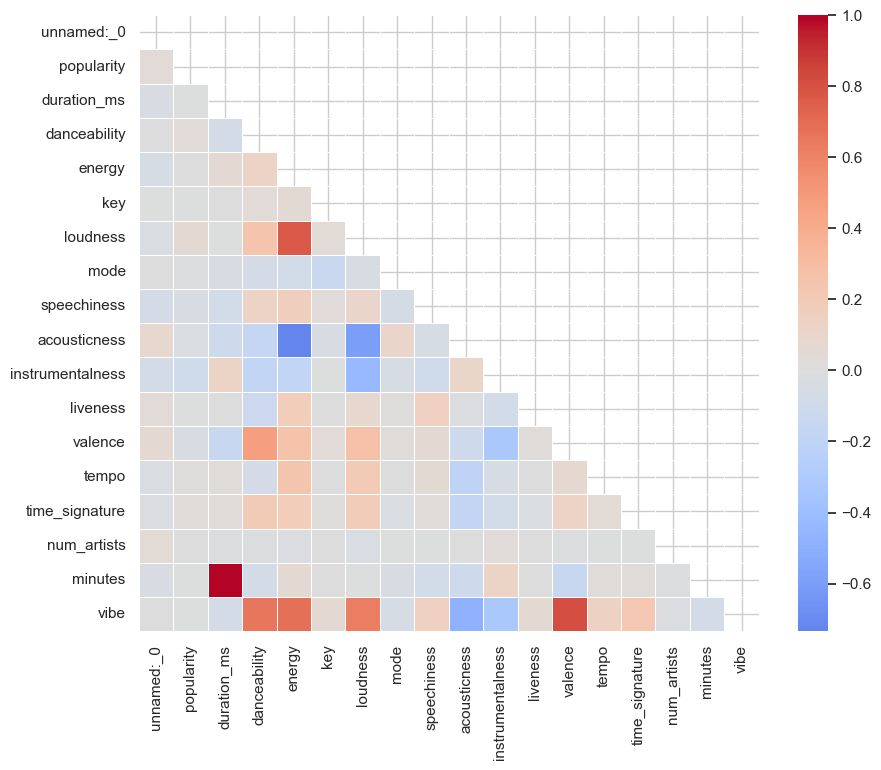

In [74]:
plt.figure(figsize=(10, 8))
corr = df.select_dtypes(include=[np.number]).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, linewidths=.5)

plt.show()

C:\Users\MY LAPTOP\AppData\Local\Temp\ipykernel_2248\658999428.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_arts.index, x=top_arts.values, palette="viridis")


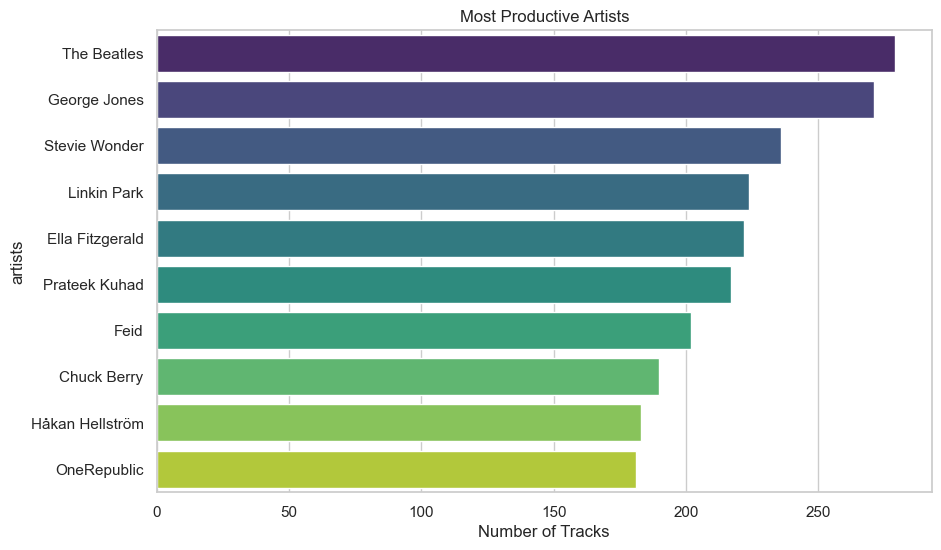

In [ ]:
top_arts = df['artists'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(y=top_arts.index, x=top_arts.values, palette="viridis")
plt.title("Most Productive Artists")
plt.xlabel("Number of Tracks")
plt.show()

C:\Users\MY LAPTOP\AppData\Local\Temp\ipykernel_2248\2385978741.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_artists.values, y=top_artists.index, palette='viridis')


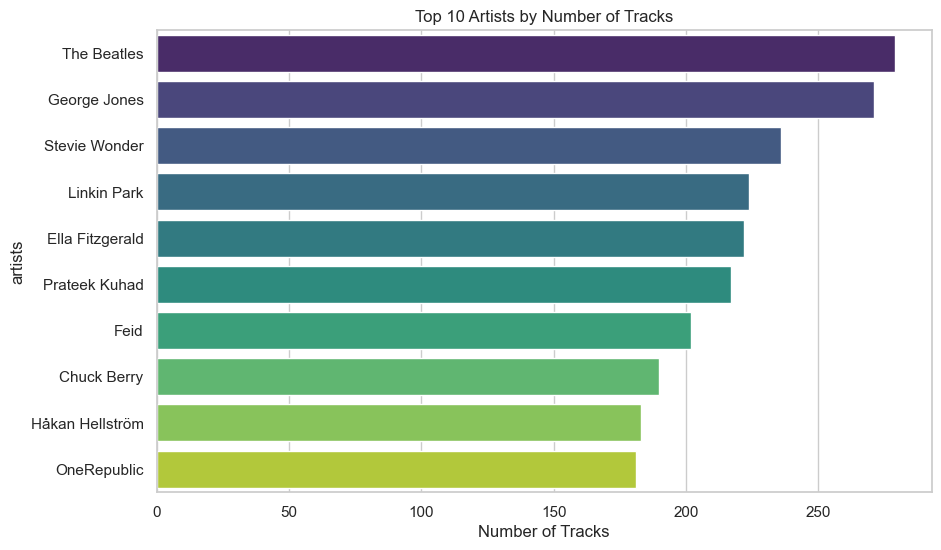

In [75]:
sns.set_theme(style="whitegrid")

top_artists = df['artists'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_artists.values, y=top_artists.index, palette='viridis')
plt.title('Top 10 Artists by Number of Tracks')
plt.xlabel('Number of Tracks')
plt.show()


C:\Users\MY LAPTOP\AppData\Local\Temp\ipykernel_2248\3014536117.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='explicit', y='popularity', palette='Set2')


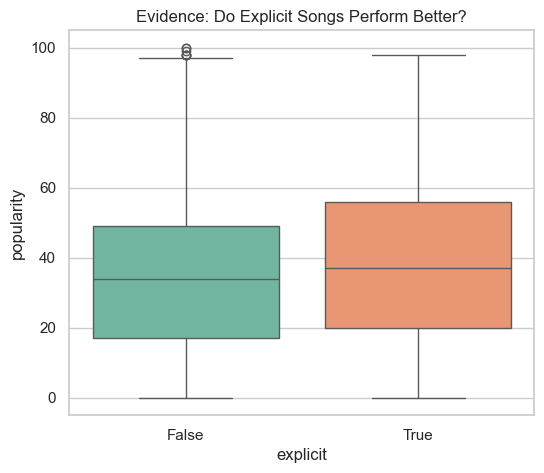

In [67]:
plt.figure(figsize=(6, 5))
sns.boxplot(data=df, x='explicit', y='popularity', palette='Set2')
plt.title("Evidence: Do Explicit Songs Perform Better?")
plt.show()

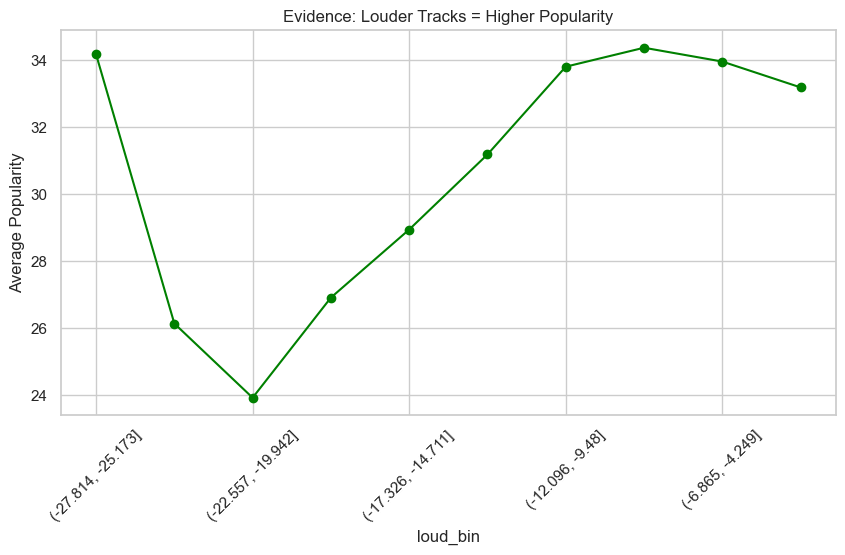

In [69]:
# Create temporary bins just for this plot
df['loud_bin'] = pd.cut(df['loudness'], bins=10)
loud_trend = df.groupby('loud_bin', observed=False)['popularity'].mean()

plt.figure(figsize=(10, 5))
loud_trend.plot(kind='line', marker='o', color='green')
plt.title("Evidence: Louder Tracks = Higher Popularity")
plt.ylabel("Average Popularity")
plt.xticks(rotation=45)
plt.show()